In [1]:
! pip install keras-tuner

In [1]:
# Import dependencies
import pandas as pd
import sklearn as skl
import tensorflow as tf

# Import the nonlinear dummy data
df_circles = pd.read_csv("https://static.bc-edx.com/ai/ail-v-1-0/m18/lesson_2/datasets/circles-data.csv")

# Split data into X and y
X = df_circles.drop("Target", axis=1)
y = df_circles["Target"]

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

<Axes: xlabel='Feature 1', ylabel='Feature 2'>

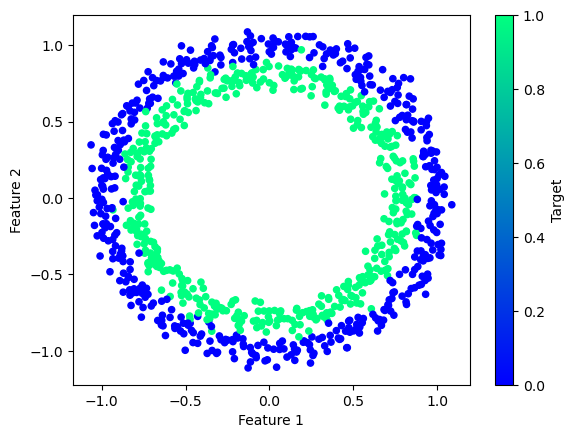

In [2]:
# Plot the nonlinear dummy data
df_circles.plot.scatter(x="Feature 1",y="Feature 2", c="Target", colormap="winter")

In [3]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=5), activation=activation, input_dim=len(X.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [4]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

/Users/stevenhill/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 01s]
val_accuracy: 0.5640000104904175

Best val_accuracy So Far: 0.9760000109672546
Total elapsed time: 00h 01m 00s


In [6]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 21, 'num_layers': 5, 'units_0': 11, 'units_1': 6, 'units_2': 21, 'units_3': 16, 'units_4': 21, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0053'}
{'activation': 'relu', 'first_units': 26, 'num_layers': 4, 'units_0': 6, 'units_1': 21, 'units_2': 16, 'units_3': 21, 'units_4': 11, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'tanh', 'first_units': 26, 'num_layers': 5, 'units_0': 21, 'units_1': 11, 'units_2': 1, 'units_3': 21, 'units_4': 16, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [7]:
# Evaluate the top 3 models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - 12ms/step - accuracy: 0.9760 - loss: 0.1133
Loss: 0.11325870454311371, Accuracy: 0.9760000109672546
8/8 - 0s - 10ms/step - accuracy: 0.9760 - loss: 0.1171
Loss: 0.11712930351495743, Accuracy: 0.9760000109672546
8/8 - 0s - 10ms/step - accuracy: 0.9560 - loss: 0.1483
Loss: 0.14825482666492462, Accuracy: 0.9559999704360962
